In [1]:
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import utils
import matplotlib.pyplot as plt
import numpy as np
import os, imageio
import torch
import cv2

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.1.0.dev20230622+cu121  Device: cuda


### Dataloader

In [3]:
torch.set_default_dtype(torch.float64)
torch.set_default_device(device)

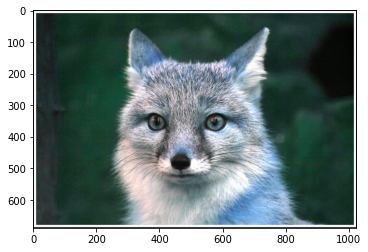

In [4]:
image_url = r"C:/Users/ayush/OneDrive\Desktop/fox.jpg"
img = cv2.imread(image_url)


plt.imshow(img)
plt.show()


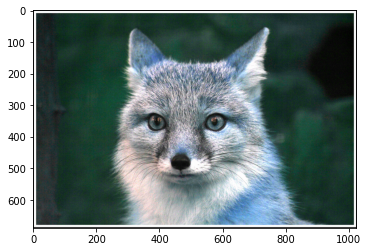

In [5]:
img = cv2.normalize(img, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_64F)

plt.imshow(img)
plt.show()

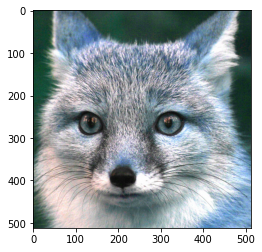

In [6]:
center = [int(img.shape[0]/2),int(img.shape[1]/2)]

r = 256

img = img[ center[0]-r:center[0]+r, center[1]-r:center[1]+r]

plt.imshow(img)
plt.show()

### Converting Dataset

In [7]:
def generate_pixel_coordinates(img):
    
    height, width, _ = img.shape

    # Generate coordinates along the x-axis and y-axis
    x_coords = np.linspace(0, 1, width, endpoint=False)
    y_coords = np.linspace(0, 1, height, endpoint=False)

    # Create a meshgrid of coordinates
    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)

    # Stack the coordinates and reshape to obtain the final output
    coordinates = np.stack([x_mesh, y_mesh], axis=-1)
    
    return coordinates

In [8]:
x_test = generate_pixel_coordinates(img)

In [9]:
test_data = [x_test, img]
train_data = [x_test[::2], img[::2]]

In [10]:
train_x = torch.tensor(train_data[0]).reshape(-1,2)
train_y = torch.tensor(train_data[1]).reshape(-1,3)
test_x = torch.tensor(test_data[0]).reshape(-1,2)
test_y = torch.tensor(test_data[1]).reshape(-1,3)

In [11]:
train_dataset = utils.data.TensorDataset(train_x,train_y)
test_dataset = utils.data.TensorDataset(test_x,test_y)

train_dataloader = utils.data.DataLoader(train_dataset,batch_size=64)
validation_dataloader = utils.data.DataLoader(test_dataset,batch_size=64)

### MLP network

In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50,3)

    def forward(self, x):
        x = x.view(-1, 2)
        x = self.relu1(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.relu2(self.fc2(x))
        x = self.fc2_drop(x)
        return self.fc3(x)

model = Net().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

print(model)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (relu1): ReLU()
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


In [14]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device).type(torch.float64)

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)
        # print(output)


        # Calculate loss
        # print(output.shape,target.shape)
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        # if batch_idx % log_interval == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_dataloader.dataset),
        #         100. * batch_idx / len(train_dataloader), loss.data.item()))

In [15]:
def validate(epoch,loss_vector, accuracy_vector,reconst = False):
    
    model.eval()
    predicted_output = np.empty([4096,64,3])
    val_loss, correct = 0, 0
    idx = 0

    for batch_idx, (data, target) in enumerate(validation_dataloader):
        
        data = data.to(device)
        target = target.to(device)
        output = model(data)

        val_loss += criterion(output, target).data.item()
        pred = output # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        
        if reconst:
            predicted_output[batch_idx] = output.detach().cpu().numpy()

        
    val_loss /= len(validation_dataloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_dataloader.dataset)
    # print(epoch,correct.to(torch.float32),len(validation_dataloader.dataset),100. * correct.to(torch.float32) / len(validation_dataloader.dataset),accuracy)
    accuracy_vector.append(accuracy)

    # print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     val_loss, correct, len(validation_dataloader.dataset), accuracy))

    if reconst:
        return predicted_output.reshape(512,512,3)
    else:
        return 0

In [16]:
%%time
epochs = 10
output_epoch = []

lossv, accv = [], []
for epoch in range(1, epochs + 1):

    train(epoch)
    output_epoch.append(validate(epoch,lossv, accv,reconst=True))


CPU times: total: 50.5 s
Wall time: 2min 24s


In [17]:
len(output_epoch)

10

In [18]:
def plot_reconstruction_progress(predicted_images, y, N=2):

  total = len(predicted_images)
  step = total // N
  plt.figure(figsize=(24, 4))

  # plot the progress of reconstructions
  for i, j in enumerate(range(0,total, step)):
      plt.subplot(1, N, i+1)
      plt.imshow(predicted_images[j])
      plt.axis("off")
      plt.title(f"iter {j}")

  # plot ground truth image
  plt.subplot(1, N+1, N+1)
  plt.imshow(y.reshape(img.shape[0],img.shape[1],3))
  plt.title('GT')
  plt.axis("off")
  plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

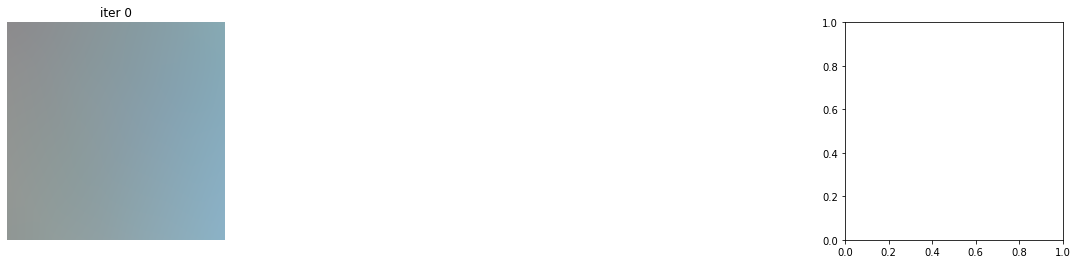

In [38]:
plot_reconstruction_progress(output_epoch,test_y)

### Helper function

In [ ]:
axiss = np.arange(10)
plt.plot(sgd_loss,color = 'r',label = 'sgd')
plt.plot(lossv,color = 'g',label = 'adam')
plt.legend()
plt.show()

## Alternate Methods

1. The training data only happens on 50% of data.
2. Test comprises of the whole dataset rather than the remaining data.

In [ ]:
tain_images, test_images = np.split(x_test, [int(len(x_test)*0.7)])

tain_images.shape
test_images.shape